In [1]:
import pandas as pd  
import seaborn as sns
import os 
import numpy as np
from itertools import compress
from scipy.stats import pearsonr

# Custom libraries
from dataloader_pickles import DataloaderEvalV5
import utils
import torch
import torch.utils.data as data


In [2]:
dirpath = r'/Users/rdijk/Documents/ProjectFA/Jupyter scripts/Saliencies'
all_files = os.listdir(dirpath)[1:]
fill = [file.startswith('saliencies') for file in all_files]
all_files = list(compress(all_files, fill))
all_files

['saliencies_200922_015124-V_E07_DMSO.csv',
 'saliencies_200922_015124-V_D19_DMSO.csv',
 'saliencies_BR00112197binned_M08_purmorphamine.csv',
 'saliencies_BR00112197binned_B20_skepinone-l.csv',
 'saliencies_200922_015124-V_I21_NVP-AEW541.csv',
 'saliencies_200922_015124-V_F12_Compound5.csv',
 'saliencies_200922_015124-V_B12_GW-3965.csv',
 'saliencies_BR00112197binned_E24_sirolimus.csv',
 'saliencies_200922_015124-V_J22_T-0901317.csv',
 'saliencies_200922_015124-V_E08_DMSO.csv',
 'saliencies_200922_015124-V_D17_DMSO.csv']

In [3]:
dataset='Stain2'
plates = ['BR00112197binned']#['200922_015124-V_FS']

# Load all data
rootDir = fr'/Users/rdijk/PycharmProjects/featureAggregation/datasets/{dataset}'
metadata = pd.read_csv('/Users/rdijk/Documents/Data/RawData/Stain2/JUMP-MOA_compound_platemap_with_metadata.csv', index_col=False)
plateDirs = [x[0] for x in os.walk(rootDir)][1:]

plateDirs = [x for x in plateDirs if any(substr in x for substr in plates)]

platestring = plateDirs[0].split('_')[-2]
print('Calculating results for: ' + platestring)
metadata = utils.addDataPathsToMetadata(rootDir, metadata, plateDirs)

# Filter the data and create numerical labels
df_prep = utils.filterData(metadata, '', encode='pert_iname')
# Add all data to one DF
Total, _ = utils.train_val_split(df_prep, 1.0, sort=False)
Total = Total.sort_values(by='Metadata_labels')

valset = DataloaderEvalV5(Total)
full_loader = data.DataLoader(valset, batch_size=1, shuffle=False, # 96
                         drop_last=False, pin_memory=False)

# WELLS = ['I21', 'F12', 'B12', 'J22']
# PERTURBATIONS = ['NVP-AEW541', 'Compound5', 'GW-3965', 'T-0901317']
point_list = [9, 37, 34] 
WELLS = list(metadata.sort_values(by='Metadata_labels').reset_index(drop=True).iloc[384-48:].reset_index(drop=True).loc[point_list, 'well_position'])
PERTURBATIONS = list(metadata.sort_values(by='Metadata_labels').reset_index(drop=True).iloc[384-48:].reset_index(drop=True).loc[point_list, 'pert_iname'])
print(WELLS, PERTURBATIONS)

Calculating results for: BR00112197binned
['M08', 'B20', 'E24'] ['purmorphamine', 'skepinone-l', 'sirolimus']


In [4]:
dataloader_list = []
for well in WELLS:
    # Load single well data
    mask = df_prep.well_position == well
    df_prep_masked = df_prep.loc[mask]
    # Add all data to one DF
    singleWell, _ = utils.train_val_split(df_prep_masked, 1.0, sort=False)

    smallset = DataloaderEvalV5(singleWell)
    dataloader = data.DataLoader(smallset, batch_size=1, shuffle=False,
                             drop_last=False, pin_memory=False)
    dataloader_list.append(dataloader)

(3147, 1324)


/Users/rdijk/miniconda3/envs/featureAggregation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(2872, 1324)


/Users/rdijk/miniconda3/envs/featureAggregation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(2138, 1324)


/Users/rdijk/miniconda3/envs/featureAggregation/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


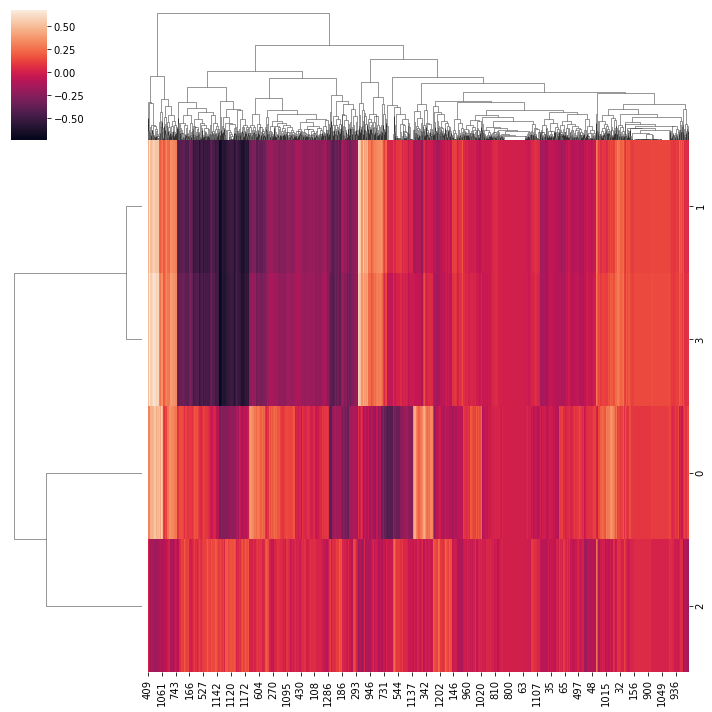

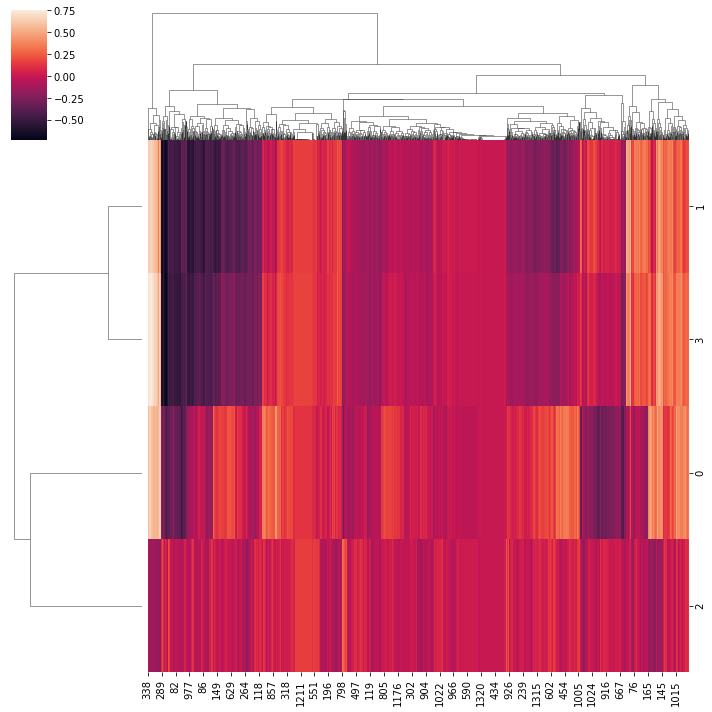

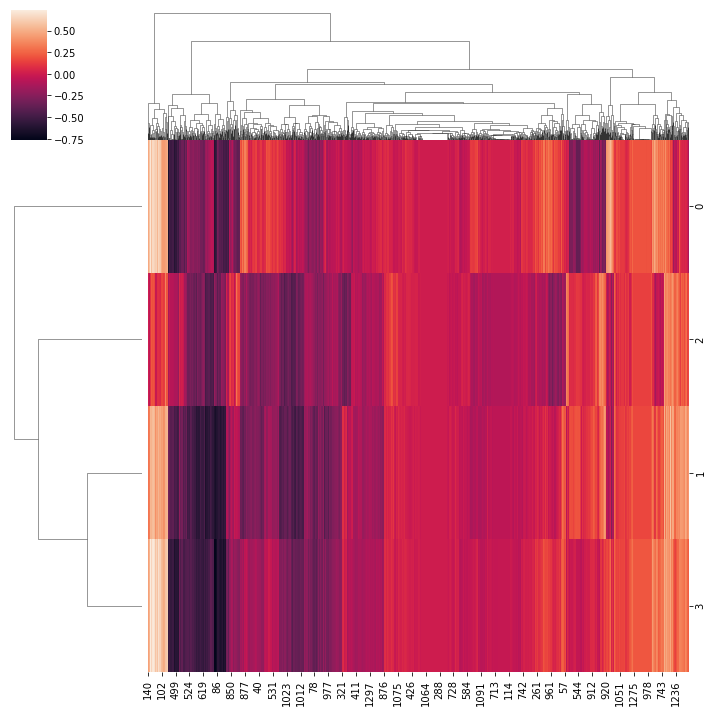

In [10]:
all_correlations = np.zeros((4,1324))
compound = None  # 0: purmorphamine, 1: skepinone-l, 2: sirolimus
for idx, loader in enumerate(dataloader_list): 
    points, clabel = next(iter(loader))
    
    matching = [s for s in all_files if WELLS[idx] in s][0]
    saliencies = pd.read_csv(os.path.join(dirpath, matching)).iloc[:, 1:-1].to_numpy()
    points = points[0, ...].numpy()
    print(points.shape)
    
    correlations = []
    for k in range(saliencies.shape[1]):
        subcorrelations = []
        for j in range(points.shape[1]):
            corr, _ = pearsonr(saliencies[:,k], points[:, j])
            subcorrelations.append(round(corr, 3))
        correlations.append(subcorrelations)
    
    correlations = np.array(correlations)
    sns.clustermap(np.nan_to_num(correlations))
    all_correlations += (correlations)
    
    if idx == compound:
        break
all_correlations /= len(dataloader_list)

In [13]:
commonfeaturenames = pd.read_csv('/Users/rdijk/Documents/Data/RawData/CommonFeatureNames.csv', index_col=False)

pd.set_option('display.max_colwidth', 60)

top_idx = 20

negativecorr = True
if negativecorr:
    indices = (all_correlations).argsort(axis=1) # Highest correlations (negative)
    st = 'NEG'
else:
    indices = (-all_correlations).argsort(axis=1) # Highest correlations (positive)
    st = 'POS'

save_name = f'/Users/rdijk/Documents/ProjectFA/FinalModelResults/SaliencyAnalysis/SALxFEATcorr{st}'

for Y in range(indices.shape[0]):
    cors = all_correlations[Y, indices[Y, :top_idx]]
    newDF = pd.DataFrame({'Features': commonfeaturenames['FeatureNames'][indices[Y, :top_idx]],
                          'Correlation': cors})
    print(f'Saliency V{Y}')
    print(newDF.iloc[:,0:].to_markdown(index=False))
    print('\n')
    newDF.to_csv(save_name+f'V{Y}.csv')


Saliency V0
| Features                                                 |   Correlation |
|:---------------------------------------------------------|--------------:|
| Cytoplasm.Cytoplasm_Correlation_K_Mito_DNA               |     -0.510667 |
| Cytoplasm.Cytoplasm_Correlation_K_Mito_RNA               |     -0.499333 |
| Cells.Cells_Correlation_K_Mito_RNA                       |     -0.483    |
| Cells.Cells_Correlation_Overlap_AGP_Brightfield          |     -0.463667 |
| Cytoplasm.Cytoplasm_Intensity_MeanIntensity_DNA          |     -0.458333 |
| Cytoplasm.Cytoplasm_Intensity_UpperQuartileIntensity_DNA |     -0.455667 |
| Cytoplasm.Cytoplasm_Intensity_MeanIntensityEdge_DNA      |     -0.423667 |
| Cells.Cells_Correlation_Overlap_Mito_RNA                 |     -0.414333 |
| Cells.Cells_Intensity_MeanIntensityEdge_DNA              |     -0.413    |
| Cells.Cells_RadialDistribution_MeanFrac_ER_4of4          |     -0.412667 |
| Cells.Cells_Intensity_MedianIntensity_DNA                |    

In [14]:
pd.set_option('display.max_colwidth', 60)

top_idx = 20 
c = (correlations[0, :] + correlations[1, :])/2
indices = (-c).argsort() # Highest correlations (positive)
#indices = c.argsort() # Highest correlations (negative)
cors = c[indices[ :top_idx]]
newDF = pd.DataFrame({'Features': commonfeaturenames['FeatureNames'][indices[:top_idx]],
                      'Corr. average': cors})
print(f'Saliency V0 + Saliency V1')
print(newDF.iloc[:,0:].to_markdown(index=False))
print('\n')



Saliency V0 + Saliency V1
| Features                                                          |   Corr. average |
|:------------------------------------------------------------------|----------------:|
| Cells.Cells_AreaShape_Area                                        |          0.6275 |
| Cytoplasm.Cytoplasm_AreaShape_Area                                |          0.626  |
| Cells.Cells_AreaShape_MeanRadius                                  |          0.615  |
| Cells.Cells_AreaShape_MaximumRadius                               |          0.608  |
| Cells.Cells_AreaShape_MedianRadius                                |          0.6075 |
| Cells.Cells_Intensity_IntegratedIntensity_Brightfield             |          0.6075 |
| Cytoplasm.Cytoplasm_Intensity_IntegratedIntensity_Brightfield     |          0.6075 |
| Cells.Cells_AreaShape_Perimeter                                   |          0.586  |
| Cytoplasm.Cytoplasm_AreaShape_MinFeretDiameter                    |          0.585  |
| Cell